In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_df = pd.read_csv("data7a.csv")

rng = np.random.RandomState(160)

In [3]:
data_df.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


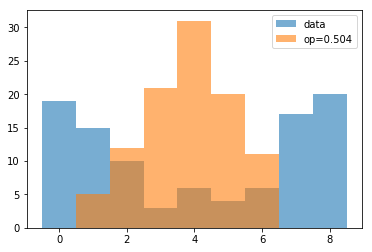

In [4]:
# 生起確率0.504で、8個取り出すのを100回繰り返し、リストに入れる。
y_list = rng.binomial(8,0.504,100)

plt.hist(data_df.y,bins=np.arange(10)-0.5,alpha=0.6,label="data")
plt.hist(y_list,bins=np.arange(10)-0.5,alpha=0.6,label="op=0.504")
plt.legend()

In [5]:
model = """
data {
    int<lower=0> N; //サンプルサイズ
    int<lower=0> y[N];//生存数
}

parameters {
    real beta;
    real r[N];　//個体差
    real <lower=0> s;　//個体差のばらつき
}

# trans-param では、data及びparametersで
# 宣言されたパラメータと定数値から、
# 新たにサンプリングする変数を作ることができる
transformed parameters {
    real q[N];
    for (i in 1:N)
        q[i] =inv_logit(beta+r[i]);
}

model {
    for (i in 1:N)
        y[i] ~ binomial(8,q[i]); //二項分布
        
    beta ~ normal(0, 100); //betaの事前分布は標準偏差100の正規分布
    
    for (i in 1:N)
        r[i] ~ normal(0,s); // rの事前分布は標準偏差s
    
    s ~ uniform(0,10000); // sの事前分布は0<s<10000の一様分布
}
"""

In [6]:
y = data_df.y
N = y.shape[0]

# stanに辞書型でデータを引き渡す
stan_data = {"N": N, "y": y}

In [7]:
import pystan


# MCMCサンプリングのステップ数
iter_count= 1600

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit = pystan.stan(model_code=model,
                  data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_69663eb8116a7e68936a182abad0dcd9 NOW.


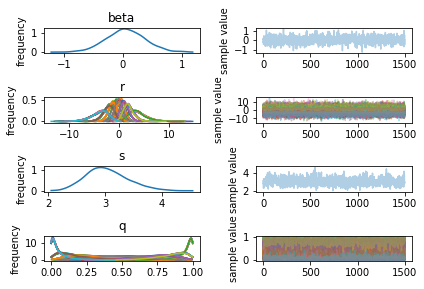

In [8]:
fit.plot()
plt.tight_layout()

In [9]:
result = fit.extract()

sample_df = pd.DataFrame()
sample_df["beta"] = result["beta"]

for i in range(result["r"].shape[1]):
    column_name = "r"+str(i+1)
    sample_df[column_name] = result["r"][:,i]
    
sample_df["s"] = result["s"]
for i in range(result["q"].shape[1]):
    column_name = "q"+str(i+1)
    sample_df[column_name] = result["q"][:,i]

In [10]:
sample_df.head()

,beta,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,q91,q92,q93,q94,q95,q96,q97,q98,q99,q100
0,0.117921,-4.324123,-0.509399,1.826308,0.638806,-2.058722,1.933169,2.746580,5.032424,-3.855157,...,0.819267,0.545710,0.999150,0.517496,0.741258,0.226464,0.007870,0.600602,0.839680,0.004642
1,0.207710,-4.343702,-1.305982,2.060028,3.364046,-2.700345,3.508382,3.733024,3.330818,-2.956070,...,0.529222,0.166902,0.889628,0.816370,0.873382,0.194970,0.033683,0.737196,0.845672,0.007475
2,-0.209659,-3.123307,-1.734358,2.333079,1.862704,-2.495485,4.665504,2.582539,5.561878,-1.668303,...,0.643080,0.205583,0.977903,0.878731,0.438161,0.054673,0.040900,0.434207,0.995190,0.012947
3,-0.059061,-4.865750,-1.681882,1.454749,3.792406,-1.172542,3.319530,2.286819,3.198405,-1.799100,...,0.792321,0.328279,0.998923,0.552675,0.493298,0.431278,0.015210,0.557541,0.960831,0.005543
4,-0.414016,-2.576890,-1.325936,1.938059,2.243704,-2.144751,3.067206,1.969793,3.373649,-0.735205,...,0.605298,0.505634,0.969980,0.881163,0.813645,0.337932,0.029135,0.461461,0.982330,0.001330


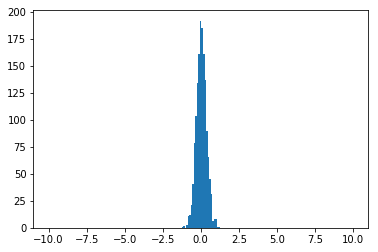

In [11]:
plt.hist(sample_df.beta,bins=np.linspace(-10,10,200))
plt.show()

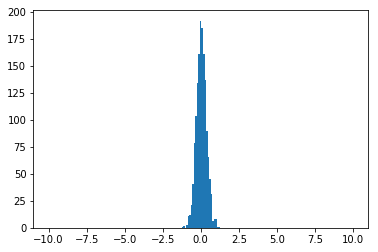

In [12]:
plt.hist(sample_df.beta,bins=np.linspace(-10,10,200))
plt.show()

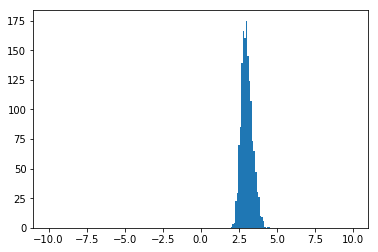

In [13]:
plt.hist(sample_df.s,bins=np.linspace(-10,10,200))
plt.show()

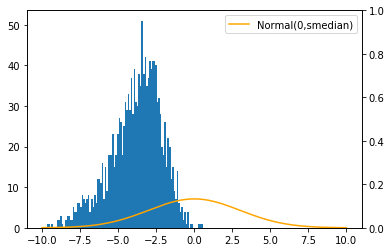

In [14]:
fig,ax1 = plt.subplots()
ax1.hist(sample_df.r1,bins=np.linspace(-10,10,200))

# sが事後分布の中央値である場合の事前分布
ax2 = ax1.twinx()

smedian = sample_df.s.median()

x = np.linspace(-10,10,2000)
y = (1.0/np.sqrt(2*np.pi*(smedian**2))) * np.exp(-(x**2)/(2*(smedian**2)))
ax2.plot(x,y,"orange",label="Normal(0,smedian)")
ax2.set(ylim=(0,1))

plt.legend()
plt.show()

In [16]:
# 個体差　+ 場所差
kb_df = pd.read_csv("./d1.csv",dtype={"pot":"category","f":"category"})

In [17]:
kb_df.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


In [18]:
kb_df[:50].describe()

,id,y
count,50.00000,50.000000
mean,25.50000,6.640000
std,14.57738,7.227386
min,1.00000,0.000000
25%,13.25000,2.000000
50%,25.50000,4.000000
75%,37.75000,8.000000
max,50.00000,29.000000


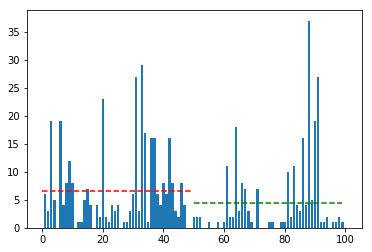

In [19]:
plt.bar(kb_df.id,kb_df.y)

mean_c = kb_df[kb_df.f.cat.codes==0].y.mean()
mean_t = kb_df[kb_df.f.cat.codes==1].y.mean()

plt.plot(np.arange(50),[mean_c]*50,"r--")
plt.plot(np.arange(50,100),[mean_t]*50,"g--")

In [20]:
print(mean_c)

6.64


In [21]:
np.sqrt(mean_c)

2.5768197453450252

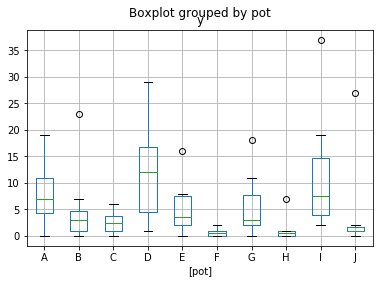

In [22]:
kb_df[["y","pot"]].boxplot(by="pot")

In [23]:
model10_5 = """
data {
  int<lower=0> N_sample;       // number of observations
  int<lower=0> N_pot;          // number of pots
  int<lower=0> N_sigma;        // number of sigmas
  int<lower=0> Y[N_sample];    // number of seeds
  int<lower=0> F[N_sample];    // fertilizer
  int<lower=0> Pot[N_sample];  // pot
}
parameters {
  real beta1;
  real beta2;
  real r[N_sample];
  real rp[N_pot];
  real<lower=0> sigma[N_sigma];
}
transformed parameters {
  real<lower=0> lambda[N_sample];

  for (i in 1:N_sample) {
    lambda[i] <- exp(beta1 + beta2 * F[i] + r[i] + rp[Pot[i]]);
  }
}
model {
  for (i in 1:N_sample) {
    Y[i] ~ poisson(lambda[i]);
  }
  beta1 ~ normal(0, 100);
  beta2 ~ normal(0, 100);
  r ~ normal(0, sigma[1]);
  rp ~ normal(0, sigma[2]);
  for (k in 1:N_sigma) {
    sigma[k] ~ uniform(0, 1.0e+4);
  }
}
"""

In [24]:
kb_df.f.cat.codes

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
79    1
80    1
81    1
82    1
83    1
84    1
85    1
86    1
87    1
88    1
89    1
90    1
91    1
92    1
93    1
94    1
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int8

In [25]:
y = kb_df.y
N_sample = kb_df.shape[0]
N_pot = kb_df.pot.drop_duplicates().shape[0]
N_sigma = 2
Y = kb_df.y
# Stanではカテゴリは0で表してはいけないようなので、
# 1足している。
F = kb_df.f.cat.codes + 1
Pot = kb_df.pot.cat.codes + 1

# stanに辞書型でデータを引き渡す
stan_data10_5 = {"y": y,"N_sample":N_sample,"N_pot":N_pot,
             "N_sigma":N_sigma,"Y":Y,"F":F,"Pot":Pot}

In [26]:
# MCMCサンプリングのステップ数
iter_count= 1000

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit10_5 = pystan.stan(model_code=model10_5,
                  data=stan_data10_5,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_461608a512c06a4653e1650bcd1fbc55 NOW.


In [27]:
fit10_5

Inference for Stan model: anon_model_461608a512c06a4653e1650bcd1fbc55.
3 chains, each with iter=1000; warmup=100; thin=3; 
post-warmup draws per chain=300, total post-warmup draws=900.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1        2.27    0.05   1.19  -0.07   1.52   2.24   3.01    4.7    621    1.0
beta2       -0.89    0.03   0.76  -2.38  -1.36  -0.86  -0.42   0.67    655    1.0
r[0]        -0.05    0.02   0.49  -1.03  -0.38  -0.05   0.27   0.92    860    1.0
r[1]        -0.61    0.02   0.58  -1.83  -0.98   -0.6  -0.22   0.47    900    1.0
r[2]         1.09    0.01   0.42   0.26    0.8   1.07   1.37   1.93    882    1.0
r[3]        -0.21    0.02   0.52  -1.27  -0.54   -0.2   0.14   0.79    890    1.0
r[4]        -1.57    0.02   0.68   -3.0  -1.98  -1.54  -1.09  -0.33    900    1.0
r[5]         1.11    0.01   0.41   0.29   0.83    1.1   1.41   1.89    900    1.0
r[6]        -0.38    0.02   0.53   -1.5  -0.73  -0.39-7.4e-3   0.66    821  

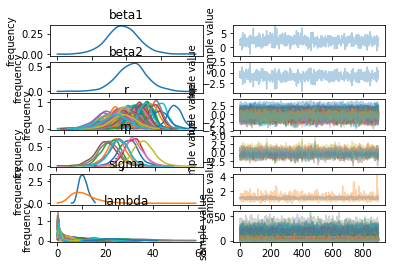

In [28]:
fit10_5.plot()
plt.show()